In [1]:
# Install Essential Libraries
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.1

In [2]:
# Import Essential Libraries
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!pip install --upgrade ultralytics ray

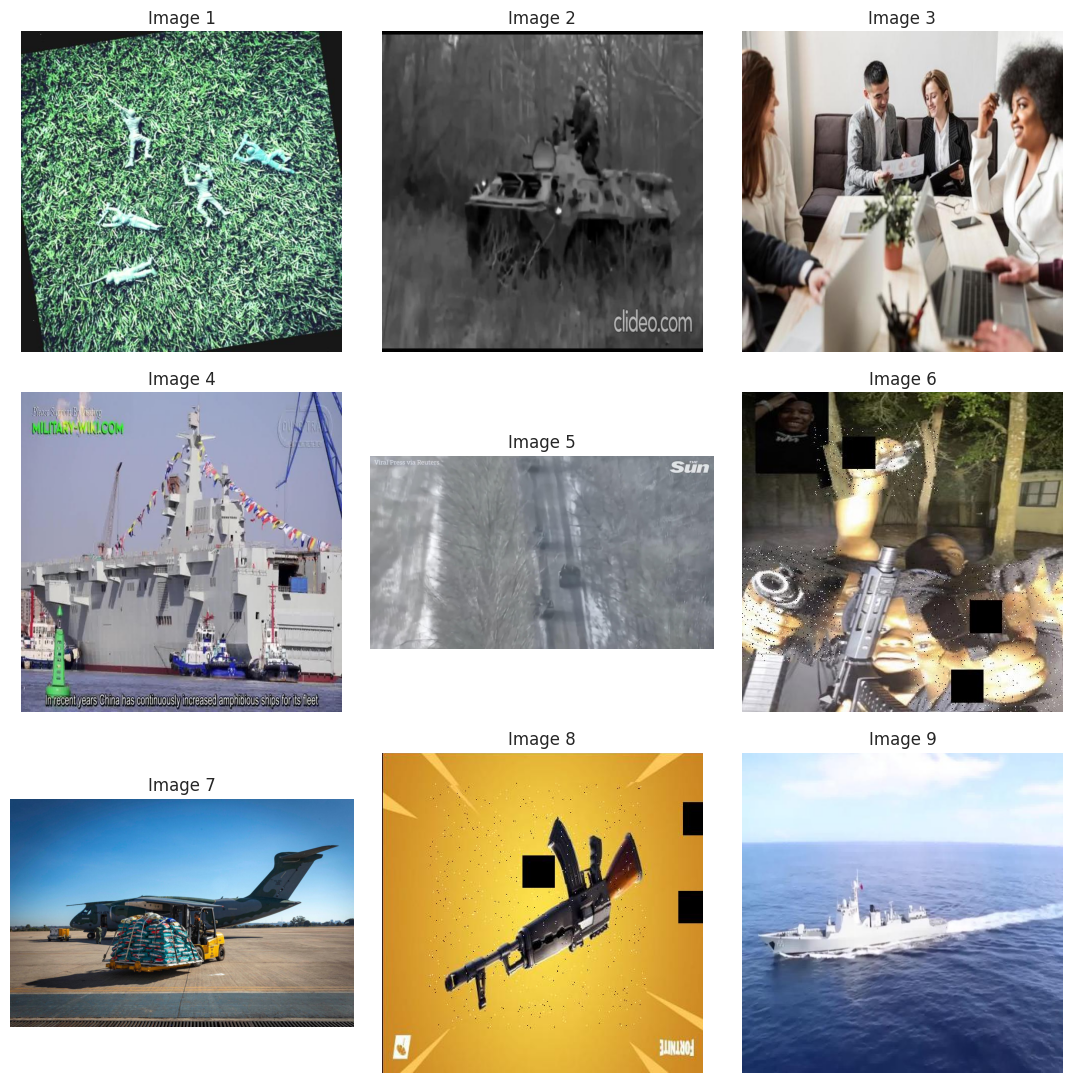

In [4]:
Image_dir = '/kaggle/input/military-object/military_object_dataset/train/images'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

In [6]:
import pandas as pd
counts = pd.Series([len(files) for files in glob.glob('train/labels/*.txt')])
print(counts.value_counts())

Series([], Name: count, dtype: int64)


In [7]:
# Get the size of the image
image = cv2.imread("/kaggle/input/military-object/military_object_dataset/train/images/002666.jpg")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 640x640 and 3 channels.


In [8]:
!cat /kaggle/input/military-object/military_object_dataset/military_dataset.yaml

path: /kaggle/input/military-assets-dataset-12-classes-yolo8-format/military_object_dataset
test: test/images
train: train/images
val: val/images

names:
  0: camouflage_soldier
  1: weapon
  2: military_tank
  3: military_truck
  4: military_vehicle
  5: civilian
  6: soldier
  7: civilian_vehicle
  8: military_artillery
  10: military_aircraft
  11: military_warship


In [9]:
import yaml

# Define correct values
correct_path = '/kaggle/input/military-object/military_object_dataset'
yaml_file_path = f'{correct_path}/military_dataset.yaml'

# Load original YAML
with open(yaml_file_path, 'r') as f:
    data = yaml.safe_load(f)

# Update the path
data['path'] = correct_path

# Update the class names to include class 9: trench
data['names'] = {
    0: 'camouflage_soldier',
    1: 'weapon',
    2: 'military_tank',
    3: 'military_truck',
    4: 'military_vehicle',
    5: 'civilian',
    6: 'soldier',
    7: 'civilian_vehicle',
    8: 'military_artillery',
    9: 'trench',
    10: 'military_aircraft',
    11: 'military_warship'
}

# Save corrected YAML to a writable location
output_yaml_path = '/kaggle/working/military_dataset_corrected.yaml'
with open(output_yaml_path, 'w') as f:
    yaml.dump(data, f)

# Display the corrected YAML file
print(f"✅ YAML file updated and saved to: {output_yaml_path}\n")
print("📄 Corrected YAML content:\n")

with open(output_yaml_path, 'r') as f:
    print(f.read())

✅ YAML file updated and saved to: /kaggle/working/military_dataset_corrected.yaml

📄 Corrected YAML content:

names:
  0: camouflage_soldier
  1: weapon
  2: military_tank
  3: military_truck
  4: military_vehicle
  5: civilian
  6: soldier
  7: civilian_vehicle
  8: military_artillery
  9: trench
  10: military_aircraft
  11: military_warship
path: /kaggle/input/military-object/military_object_dataset
test: test/images
train: train/images
val: val/images



In [10]:
from ultralytics import YOLO
import cv2

# 1. Verify dataset YAML path
dataset_yaml = "military_dataset_corrected.yaml"
assert os.path.exists(dataset_yaml), f"Dataset YAML not found at {dataset_yaml}"

# 2. Load medium model (best accuracy/speed tradeoff)
model = YOLO('yolov8n.pt')  

# 3. Train with Kaggle-optimized settings
results = model.train(
    data=dataset_yaml,
    imgsz=480,       # Reduce to 480 or 320 if OOM/slow
    batch=24,        # Max batch for T4 (12 if OOM)
    epochs=70,
    #device='0',      # Use GPU
    amp=True,        # ✅ Enable mixed-precision (faster!)
    workers=4,       # Increase if Kaggle allows
    optimizer='Adam', # Faster than 'auto' (SGD)
    lr0=0.001,       # Lower LR for stability
    patience=3,
    mosaic=0.5,  # Less intensive augmentation
    degrees=5.0, # Smaller rotation range# Slightly higher patience
    cos_lr=True,     # Good for convergence
    cache=True,      # ✅ Cache dataset (HUGE speed boost!)
    pretrained=True, # Ensure pretrained weights are used
    single_cls=False,
    project='/kaggle/working/train_results'
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 89.2MB/s]


Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=military_dataset_corrected.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=3, perspective=0.0, plots=True, pose=12.0, pretrained

100%|██████████| 755k/755k [00:00<00:00, 26.0MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 40.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.1 ms, read: 13.8±8.3 MB/s, size: 76.5 KB)


train: Scanning /kaggle/input/military-object/military_object_dataset/train/labels... 44298 images, 1161 backgrounds, 1 corrupt: 100%|██████████| 44350/44350 [03:28<00:00, 212.30it/s]

train: /kaggle/input/military-object/military_object_dataset/train/images/gun_96_jpeg.rf.aeee6bf8f2d9165e73e8385a93ab2cc0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0916]


WARNING ⚠️ train: Cache directory /kaggle/input/military-object/military_object_dataset/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 480, len(boxes) = 89085. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
WARNING ⚠️ train: 37.5GB RAM required to cache images with 50% safety margin but only 28.9/31.4GB available, not caching images
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 41.1±36.3 MB/s, size: 378.7 KB)


val: Scanning /kaggle/input/military-object/military_object_dataset/val/labels... 2941 images, 273 backgrounds, 0 corrupt: 100%|██████████| 2941/2941 [00:13<00:00, 211.57it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/military-object/military_object_dataset/val is not writeable, cache not saved.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.5GB RAM): 100%|██████████| 2941/2941 [00:12<00:00, 226.99it/s]


Plotting labels to /kaggle/working/train_results/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to /kaggle/working/train_results/train
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      2.65G      1.319      1.924      1.425         69        480: 100%|██████████| 1848/1848 [06:08<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.56it/s]


                   all       2941       5081      0.254      0.221       0.18      0.093

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      2.68G      1.242      1.532      1.379         65        480: 100%|██████████| 1848/1848 [05:46<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.13it/s]


                   all       2941       5081      0.394      0.231      0.232      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70       2.7G      1.231      1.473      1.373         63        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.17it/s]


                   all       2941       5081      0.283      0.341      0.278      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      2.71G      1.171      1.346      1.334         69        480: 100%|██████████| 1848/1848 [05:42<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.07it/s]


                   all       2941       5081      0.338      0.339      0.308      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      2.73G       1.14      1.268      1.313         63        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.15it/s]


                   all       2941       5081      0.342      0.352      0.334      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      2.75G      1.118      1.222      1.298         65        480: 100%|██████████| 1848/1848 [05:46<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.27it/s]


                   all       2941       5081      0.397      0.355      0.366      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      2.76G      1.101      1.186      1.286         74        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.31it/s]

                   all       2941       5081      0.424       0.38      0.385      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      2.78G      1.085      1.159      1.275         50        480: 100%|██████████| 1848/1848 [05:43<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.28it/s]


                   all       2941       5081       0.49       0.37      0.391      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70       2.8G      1.075       1.14      1.269         61        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.30it/s]


                   all       2941       5081      0.432      0.407      0.405      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      2.81G      1.061      1.123       1.26         55        480: 100%|██████████| 1848/1848 [05:48<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.33it/s]


                   all       2941       5081       0.42       0.41      0.411      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      2.83G      1.057      1.104      1.258         49        480: 100%|██████████| 1848/1848 [05:46<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.18it/s]


                   all       2941       5081      0.443      0.421       0.42      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      3.12G      1.053      1.095      1.252         67        480: 100%|██████████| 1848/1848 [05:50<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.09it/s]

                   all       2941       5081      0.439      0.431      0.432      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      3.13G      1.043       1.07      1.246        139        480: 100%|██████████| 1848/1848 [05:47<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.31it/s]

                   all       2941       5081      0.443      0.438       0.43      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      3.15G       1.03      1.063      1.241         74        480: 100%|██████████| 1848/1848 [05:52<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.91it/s]


                   all       2941       5081      0.449      0.446      0.448      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      3.17G      1.025      1.043      1.238         63        480: 100%|██████████| 1848/1848 [05:48<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.19it/s]

                   all       2941       5081      0.468      0.446      0.447      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      3.19G       1.02      1.034      1.234         62        480: 100%|██████████| 1848/1848 [05:48<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.00it/s]


                   all       2941       5081      0.447      0.444      0.446      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70       3.2G      1.021      1.032      1.232         43        480: 100%|██████████| 1848/1848 [05:48<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.30it/s]


                   all       2941       5081      0.468      0.454      0.454      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      3.22G      1.017       1.02      1.229         51        480: 100%|██████████| 1848/1848 [05:47<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.35it/s]


                   all       2941       5081      0.459      0.459      0.452      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      3.24G      1.007      1.008      1.225        102        480: 100%|██████████| 1848/1848 [05:51<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.36it/s]


                   all       2941       5081      0.467      0.452       0.46       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      3.25G      1.002      1.002      1.221         47        480: 100%|██████████| 1848/1848 [05:51<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.08it/s]

                   all       2941       5081      0.471       0.46      0.465      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      3.27G      1.002     0.9965      1.217         73        480: 100%|██████████| 1848/1848 [05:51<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.07it/s]

                   all       2941       5081      0.483      0.457      0.466      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      3.29G     0.9968     0.9864      1.218        132        480: 100%|██████████| 1848/1848 [05:49<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.16it/s]

                   all       2941       5081      0.482      0.464       0.47      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70       3.3G     0.9892     0.9707      1.209         66        480: 100%|██████████| 1848/1848 [05:51<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.29it/s]


                   all       2941       5081      0.485      0.468      0.471      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      3.32G     0.9837     0.9661      1.207         43        480: 100%|██████████| 1848/1848 [05:56<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.16it/s]

                   all       2941       5081       0.49      0.463      0.472      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      3.34G     0.9788     0.9557      1.204         56        480: 100%|██████████| 1848/1848 [05:48<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.97it/s]

                   all       2941       5081      0.491      0.465      0.474      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      3.35G     0.9763     0.9517      1.203        114        480: 100%|██████████| 1848/1848 [05:44<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.22it/s]

                   all       2941       5081      0.484      0.468      0.475        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      3.37G     0.9717     0.9488        1.2         48        480: 100%|██████████| 1848/1848 [05:50<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.28it/s]

                   all       2941       5081      0.488      0.468      0.477      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      3.39G     0.9646     0.9343      1.196         49        480: 100%|██████████| 1848/1848 [05:47<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.34it/s]

                   all       2941       5081      0.491      0.468      0.478      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      3.41G     0.9685      0.929      1.194         68        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.05it/s]

                   all       2941       5081      0.495      0.469       0.48      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      3.42G     0.9583     0.9143      1.188         68        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.18it/s]

                   all       2941       5081      0.501      0.469      0.481      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      3.44G     0.9584     0.9088       1.19         50        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.27it/s]

                   all       2941       5081      0.498      0.468      0.482      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      3.46G     0.9503     0.9014      1.185         66        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.29it/s]

                   all       2941       5081      0.507      0.466      0.482      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      3.47G     0.9501     0.8968      1.181         78        480: 100%|██████████| 1848/1848 [05:45<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.37it/s]

                   all       2941       5081      0.504      0.467      0.483      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      3.49G     0.9376     0.8864      1.177         63        480: 100%|██████████| 1848/1848 [05:46<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.30it/s]

                   all       2941       5081      0.508      0.466      0.484      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      3.51G     0.9404     0.8839      1.176         71        480: 100%|██████████| 1848/1848 [05:46<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.13it/s]

                   all       2941       5081      0.509      0.466      0.486      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      3.53G     0.9326     0.8711      1.175         64        480: 100%|██████████| 1848/1848 [05:48<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.09it/s]

                   all       2941       5081      0.514      0.465      0.487       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      3.54G     0.9279     0.8637       1.17         75        480: 100%|██████████| 1848/1848 [05:48<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.22it/s]

                   all       2941       5081      0.509      0.471      0.487      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      3.56G     0.9228     0.8521      1.165         61        480: 100%|██████████| 1848/1848 [05:47<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.29it/s]

                   all       2941       5081      0.512      0.473      0.488      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      3.58G     0.9227     0.8497      1.167         43        480: 100%|██████████| 1848/1848 [05:52<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.18it/s]

                   all       2941       5081      0.512       0.47      0.488      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      3.96G      0.917     0.8442      1.162         55        480: 100%|██████████| 1848/1848 [05:52<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.28it/s]

                   all       2941       5081      0.518      0.467       0.49      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      3.97G     0.9102     0.8284       1.16         59        480: 100%|██████████| 1848/1848 [05:52<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.28it/s]

                   all       2941       5081      0.524      0.467      0.491      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      3.99G     0.9035     0.8239      1.153         72        480: 100%|██████████| 1848/1848 [05:52<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.24it/s]

                   all       2941       5081      0.531      0.466      0.492      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      4.01G     0.9037     0.8144      1.151         79        480: 100%|██████████| 1848/1848 [05:52<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.28it/s]

                   all       2941       5081       0.53      0.467      0.494      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      4.02G     0.8967     0.8125      1.149         50        480: 100%|██████████| 1848/1848 [05:52<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.31it/s]

                   all       2941       5081       0.53      0.468      0.495      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      4.04G     0.8931     0.8038      1.146         66        480: 100%|██████████| 1848/1848 [05:54<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.20it/s]

                   all       2941       5081      0.527      0.468      0.495       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      4.06G     0.8872     0.7934      1.144         52        480: 100%|██████████| 1848/1848 [05:56<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.27it/s]

                   all       2941       5081      0.531      0.464      0.496      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      4.07G     0.8814     0.7844      1.139         53        480: 100%|██████████| 1848/1848 [05:51<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]

                   all       2941       5081      0.531      0.463      0.498      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      4.09G     0.8759     0.7776      1.137         81        480: 100%|██████████| 1848/1848 [05:50<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.24it/s]

                   all       2941       5081      0.531      0.465      0.499      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      4.11G      0.876     0.7678      1.136         54        480: 100%|██████████| 1848/1848 [05:42<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.22it/s]

                   all       2941       5081      0.532      0.465      0.499      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      4.13G     0.8707     0.7626      1.131         55        480: 100%|██████████| 1848/1848 [05:40<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.20it/s]

                   all       2941       5081      0.533      0.464        0.5      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      4.14G     0.8646     0.7562       1.13         46        480: 100%|██████████| 1848/1848 [05:44<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]

                   all       2941       5081      0.532      0.463      0.501      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      4.16G     0.8601     0.7497      1.125        106        480: 100%|██████████| 1848/1848 [05:43<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.23it/s]

                   all       2941       5081      0.536      0.461      0.502      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      4.18G     0.8563     0.7399      1.126         65        480: 100%|██████████| 1848/1848 [05:39<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.25it/s]

                   all       2941       5081      0.554      0.453      0.503      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      4.19G     0.8489     0.7314      1.121         68        480: 100%|██████████| 1848/1848 [05:39<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.82it/s]

                   all       2941       5081       0.56      0.451      0.504      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      4.21G     0.8496     0.7274       1.12         49        480: 100%|██████████| 1848/1848 [05:38<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.20it/s]

                   all       2941       5081      0.565       0.45      0.505       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      4.23G     0.8427     0.7208      1.118         47        480: 100%|██████████| 1848/1848 [05:39<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.26it/s]

                   all       2941       5081       0.57      0.449      0.507      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      4.25G      0.844      0.718      1.115         58        480: 100%|██████████| 1848/1848 [05:39<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.92it/s]

                   all       2941       5081      0.571      0.449      0.508      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      4.26G      0.833     0.7086      1.112         84        480: 100%|██████████| 1848/1848 [05:40<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.30it/s]

                   all       2941       5081       0.57      0.451       0.51      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      4.28G     0.8327      0.708      1.112         43        480: 100%|██████████| 1848/1848 [05:46<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.19it/s]

                   all       2941       5081      0.576      0.451      0.511      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70       4.3G     0.8322     0.6994       1.11         51        480: 100%|██████████| 1848/1848 [05:43<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.18it/s]

                   all       2941       5081      0.573      0.453      0.513      0.336


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      4.31G     0.7845     0.5871      1.081         38        480: 100%|██████████| 1848/1848 [05:39<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.16it/s]

                   all       2941       5081      0.557      0.461      0.513      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      4.33G     0.7817     0.5759      1.079         36        480: 100%|██████████| 1848/1848 [05:34<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.25it/s]

                   all       2941       5081      0.556      0.464      0.515      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      4.35G     0.7802     0.5731      1.076         34        480: 100%|██████████| 1848/1848 [05:35<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.31it/s]

                   all       2941       5081       0.55      0.471      0.516      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      4.37G     0.7761     0.5674      1.075         59        480: 100%|██████████| 1848/1848 [05:30<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.25it/s]

                   all       2941       5081       0.55      0.473      0.516      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      4.38G     0.7734     0.5653      1.072         32        480: 100%|██████████| 1848/1848 [05:37<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.25it/s]

                   all       2941       5081      0.552      0.475      0.517      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70       4.4G     0.7691     0.5608      1.071         42        480: 100%|██████████| 1848/1848 [05:38<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.21it/s]

                   all       2941       5081       0.55       0.48      0.518       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      4.42G     0.7698     0.5587       1.07         43        480: 100%|██████████| 1848/1848 [05:36<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.29it/s]

                   all       2941       5081      0.551      0.482      0.519       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      4.44G     0.7685     0.5572      1.069         38        480: 100%|██████████| 1848/1848 [05:31<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.25it/s]

                   all       2941       5081      0.554      0.484       0.52       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      4.45G      0.766     0.5556      1.069         38        480: 100%|██████████| 1848/1848 [05:36<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.30it/s]

                   all       2941       5081      0.557      0.486      0.521      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      4.47G     0.7669      0.555      1.069         60        480: 100%|██████████| 1848/1848 [05:32<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.15it/s]

                   all       2941       5081      0.558      0.486      0.522      0.341



70 epochs completed in 6.965 hours.
Optimizer stripped from /kaggle/working/train_results/train/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/train_results/train/weights/best.pt, 6.2MB

Validating /kaggle/working/train_results/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.59it/s]


                   all       2941       5081      0.558      0.486      0.522      0.342
    camouflage_soldier        385        510      0.727      0.765      0.781      0.438
                weapon        222        358      0.713      0.547      0.577      0.422
         military_tank        938       1787      0.771      0.847      0.842      0.566
        military_truck         84        148      0.468      0.649       0.62      0.398
      military_vehicle        149        307      0.689      0.468       0.54      0.387
              civilian          1          1          0          0   0.000481   0.000144
               soldier        420        745      0.818      0.646      0.731      0.426
      civilian_vehicle         18         42      0.501      0.383      0.399      0.233
    military_artillery         85        117       0.65      0.239        0.4      0.266
                trench          1          3          0          0          0          0
     military_aircraf

In [11]:
metrics = model.val(
    data='military_dataset_corrected.yaml',
    split='val',    # Or 'test'
    conf=0.25,      # Confidence threshold
    iou=0.6         # IoU threshold
)
print(f"Final mAP50-95: {metrics.box.map}")  # Should be >0.3

Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 237.5±216.4 MB/s, size: 190.3 KB)


val: Scanning /kaggle/input/military-object/military_object_dataset/val/labels... 2941 images, 273 backgrounds, 0 corrupt: 100%|██████████| 2941/2941 [00:05<00:00, 570.71it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/military-object/military_object_dataset/val is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.5GB RAM): 100%|██████████| 2941/2941 [00:11<00:00, 249.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:14<00:00,  8.40it/s]


                   all       2941       5081      0.563      0.491      0.549      0.394
    camouflage_soldier        385        510      0.736      0.767      0.788       0.49
                weapon        222        358      0.762      0.553      0.693      0.547
         military_tank        938       1787      0.777      0.851      0.845      0.612
        military_truck         84        148      0.464      0.655      0.629      0.434
      military_vehicle        149        307      0.682      0.476      0.563      0.443
              civilian          1          1          0          0          0          0
               soldier        420        745      0.829       0.65      0.772      0.498
      civilian_vehicle         18         42      0.486      0.405       0.47      0.308
    military_artillery         85        117      0.636      0.239      0.407      0.317
                trench          1          3          0          0          0          0
     military_aircraf

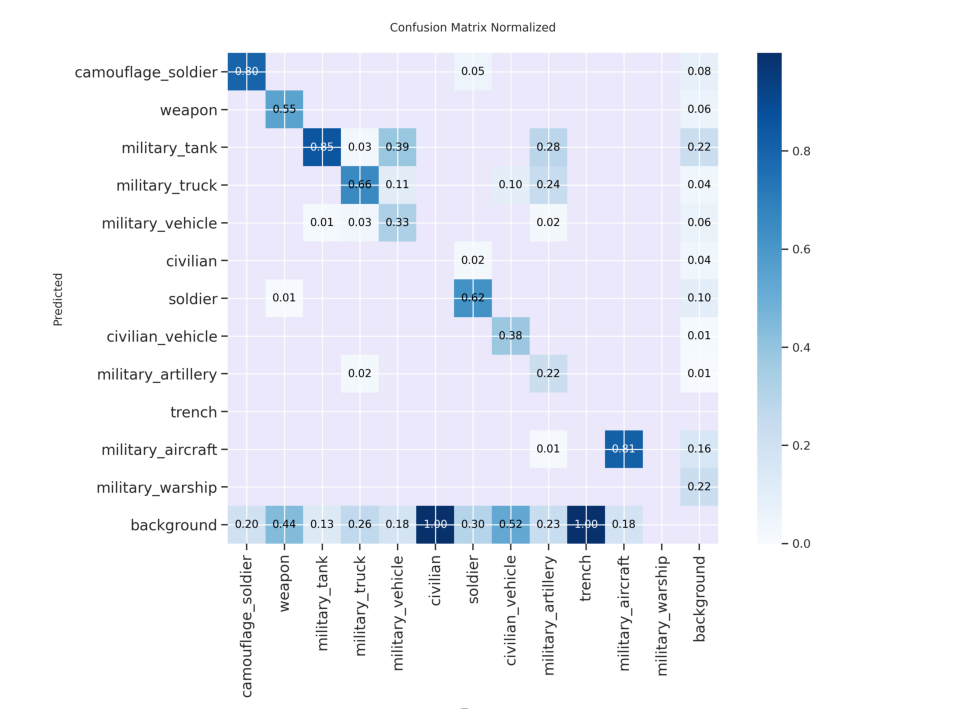

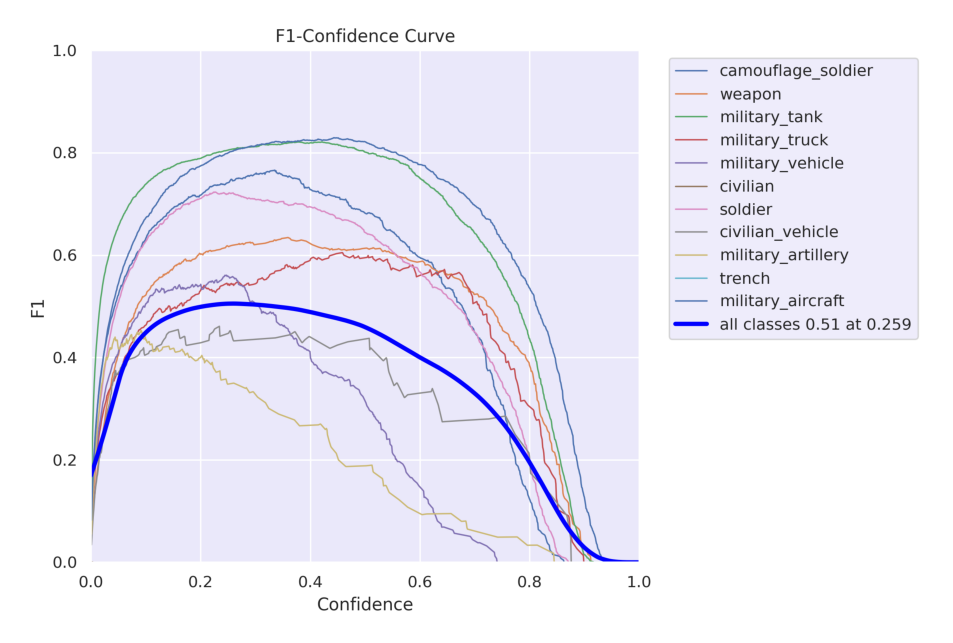

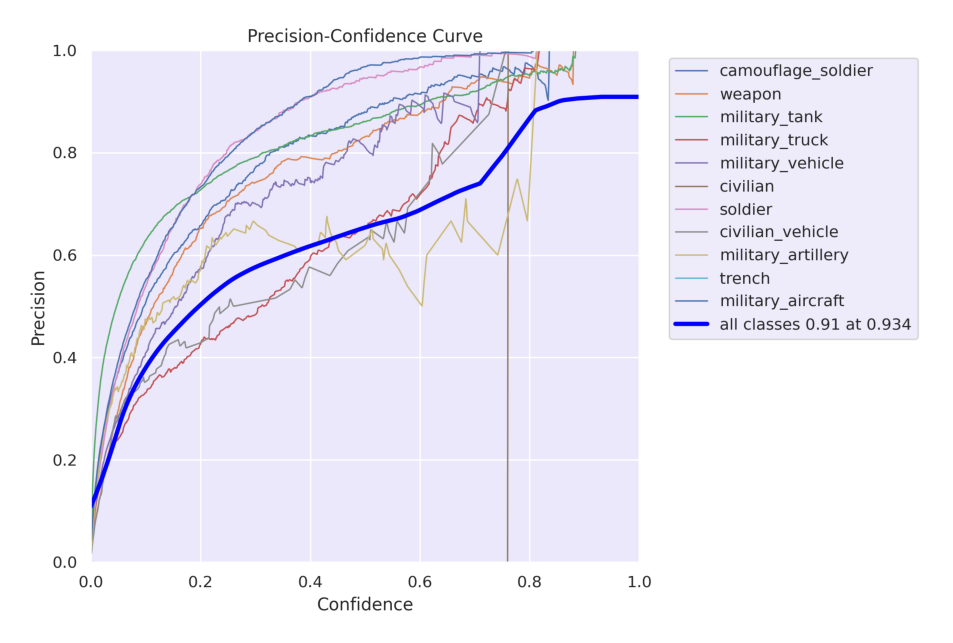

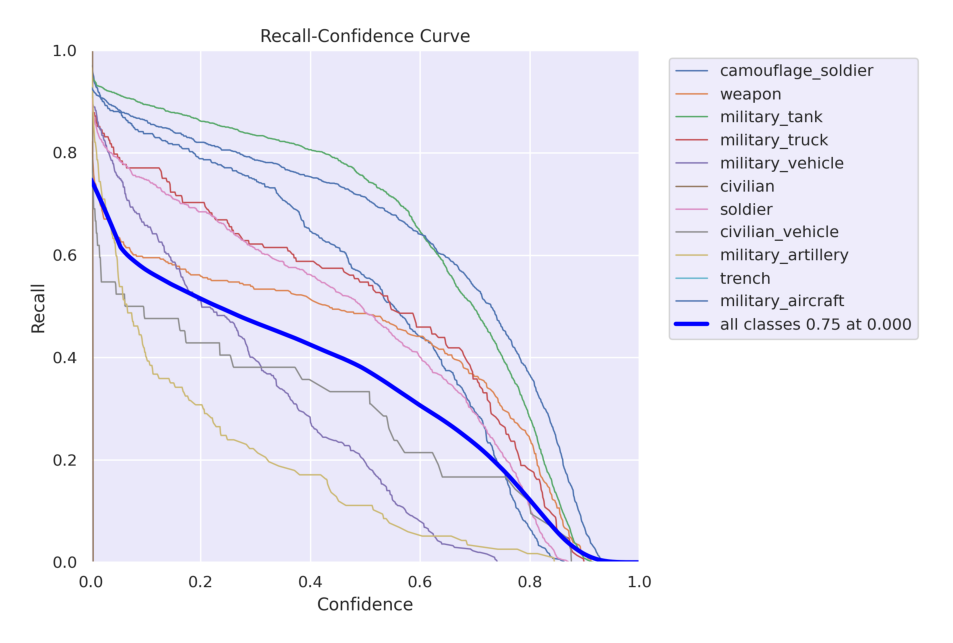

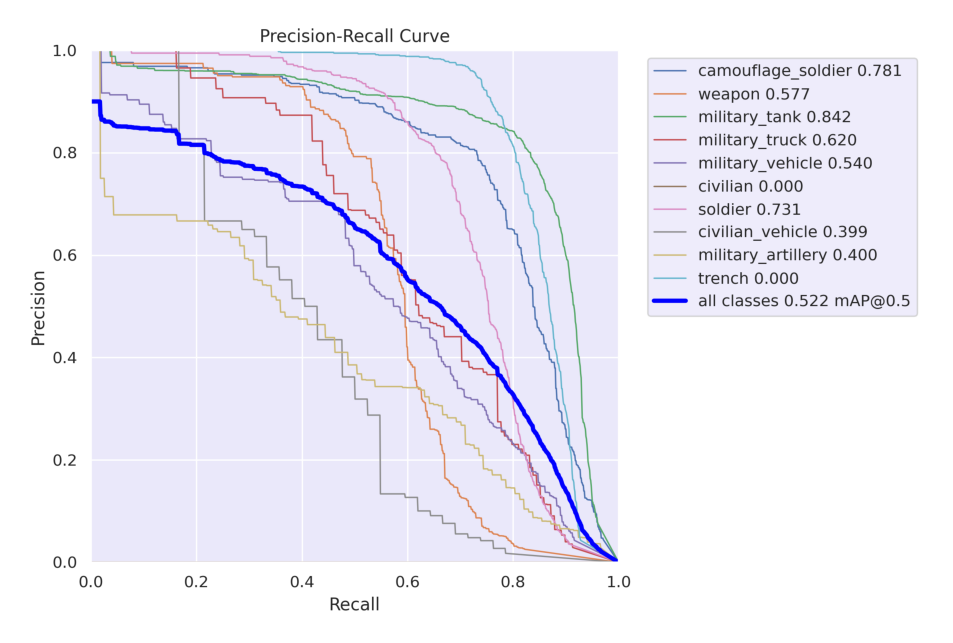

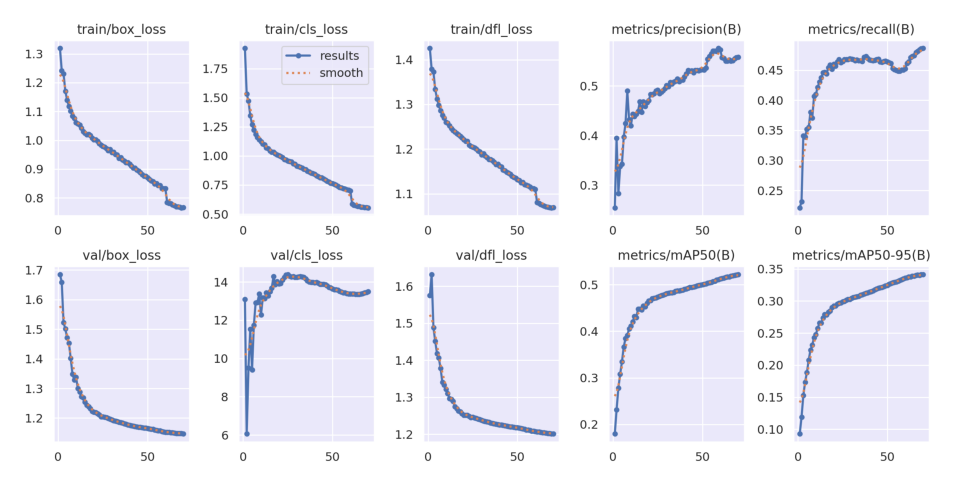

In [12]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = '/kaggle/working/train_results/train'

# Display the images
display_images(post_training_files_path, image_files)

In [13]:
results = pd.read_csv('/kaggle/working/train_results/train/results.csv')
results.tail(10)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
60,61,21951.9,0.78449,0.58710,1.08050,0.55705,0.46117,0.51348,0.33635,1.15205,13.3777,1.20689,0.000059,0.000059,0.000059
61,62,22298.2,0.78173,0.57595,1.07912,0.55590,0.46388,0.51451,0.33736,1.15161,13.3708,1.20626,0.000050,0.000050,0.000050
62,63,22645.5,0.78021,0.57313,1.07616,0.55040,0.47121,0.51575,0.33761,1.15062,13.3646,1.20536,0.000042,0.000042,0.000042
63,64,22988.5,0.77614,0.56737,1.07468,0.55034,0.47287,0.51649,0.33866,1.15031,13.3531,1.20478,0.000034,0.000034,0.000034
64,65,23338.3,0.77345,0.56531,1.07230,0.55212,0.47452,0.51684,0.33902,1.14986,13.3510,1.20444,0.000028,0.000028,0.000028
65,66,23689.2,0.76908,0.56078,1.07088,0.54981,0.47968,0.51799,0.33982,1.14870,13.3716,1.20344,0.000022,0.000022,0.000022
66,67,24037.8,0.76984,0.55870,1.07016,0.55130,0.48163,0.51901,0.34040,1.14802,13.4039,1.20253,0.000018,0.000018,0.000018
67,68,24381.0,0.76847,0.55725,1.06922,0.55448,0.48380,0.52044,0.34031,1.14754,13.4410,1.20199,0.000014,0.000014,0.000014
68,69,24729.3,0.76599,0.55559,1.06876,0.55696,0.48619,0.52120,0.34096,1.14768,13.4581,1.20188,0.000012,0.000012,0.000012
69,70,25074.3,0.76692,0.55499,1.06905,0.55789,0.48643,0.52192,0.34142,1.14678,13.4893,1.20138,0.000010,0.000010,0.000010


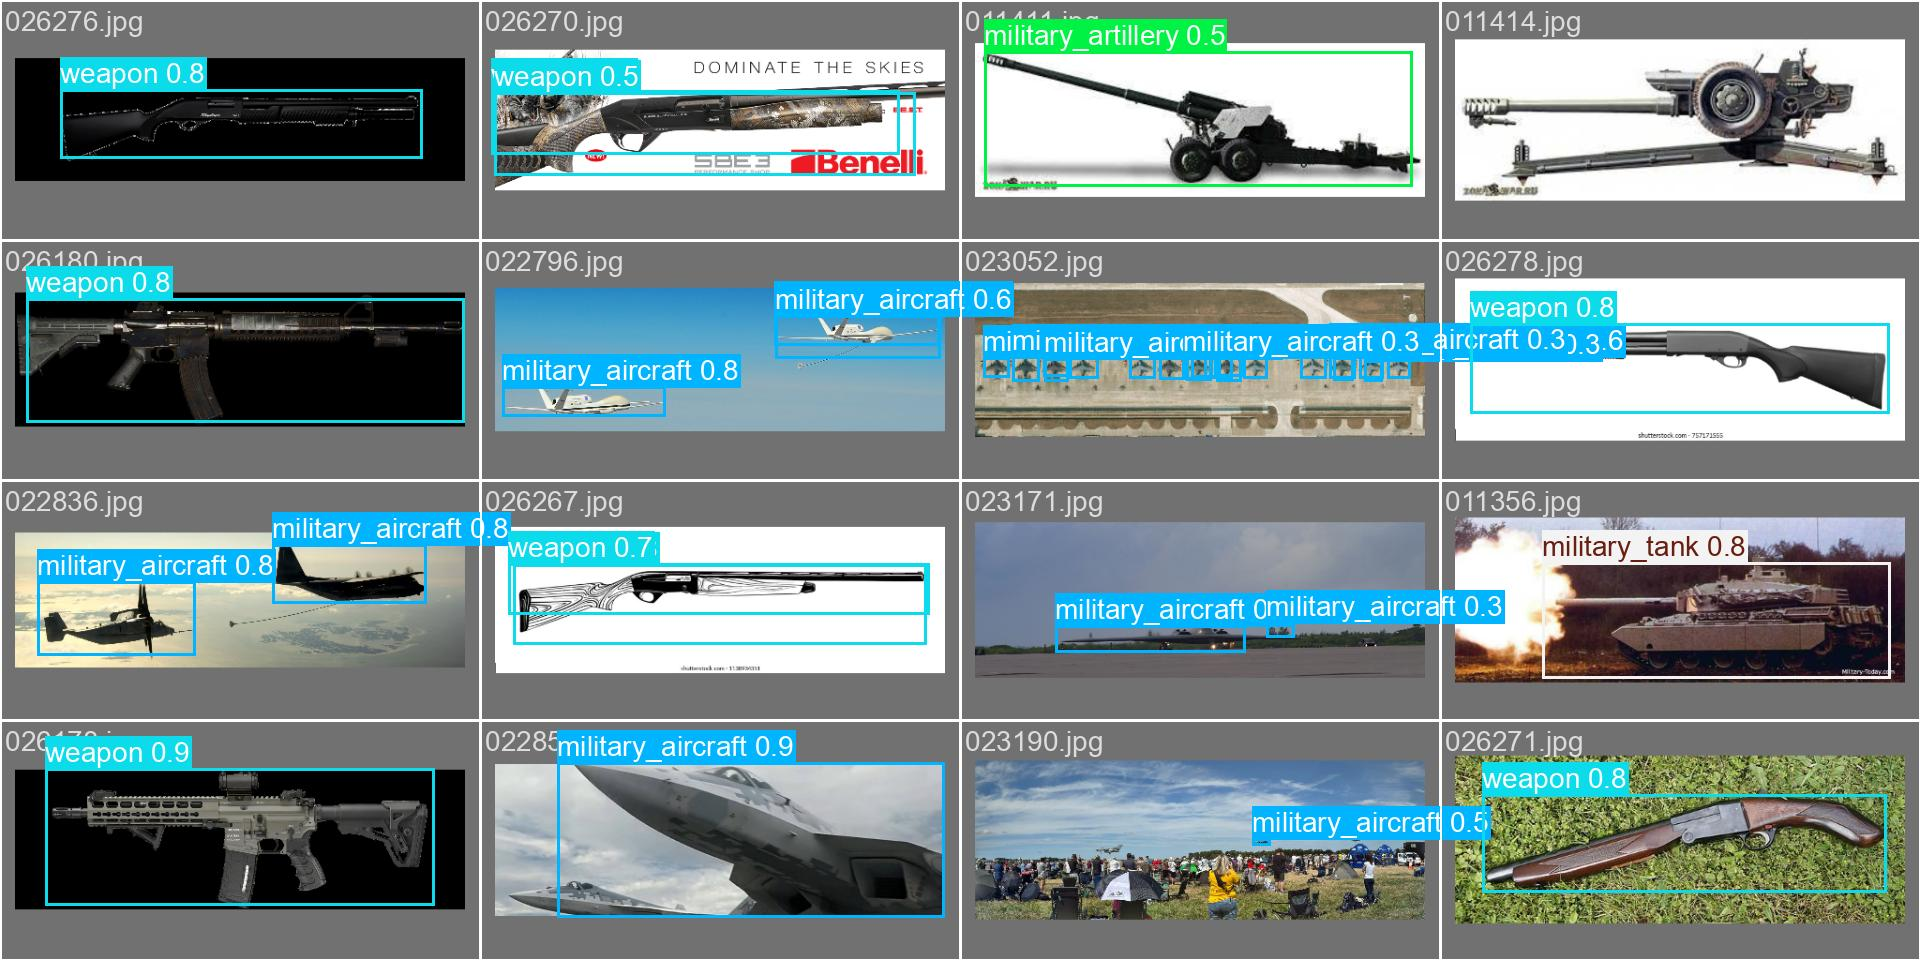

In [14]:
from IPython.display import Image

# Display training results
Image(filename='/kaggle/working/train_results/train/results.png')

# Show validation predictions
Image(filename='/kaggle/working/train_results/train/val_batch0_pred.jpg')

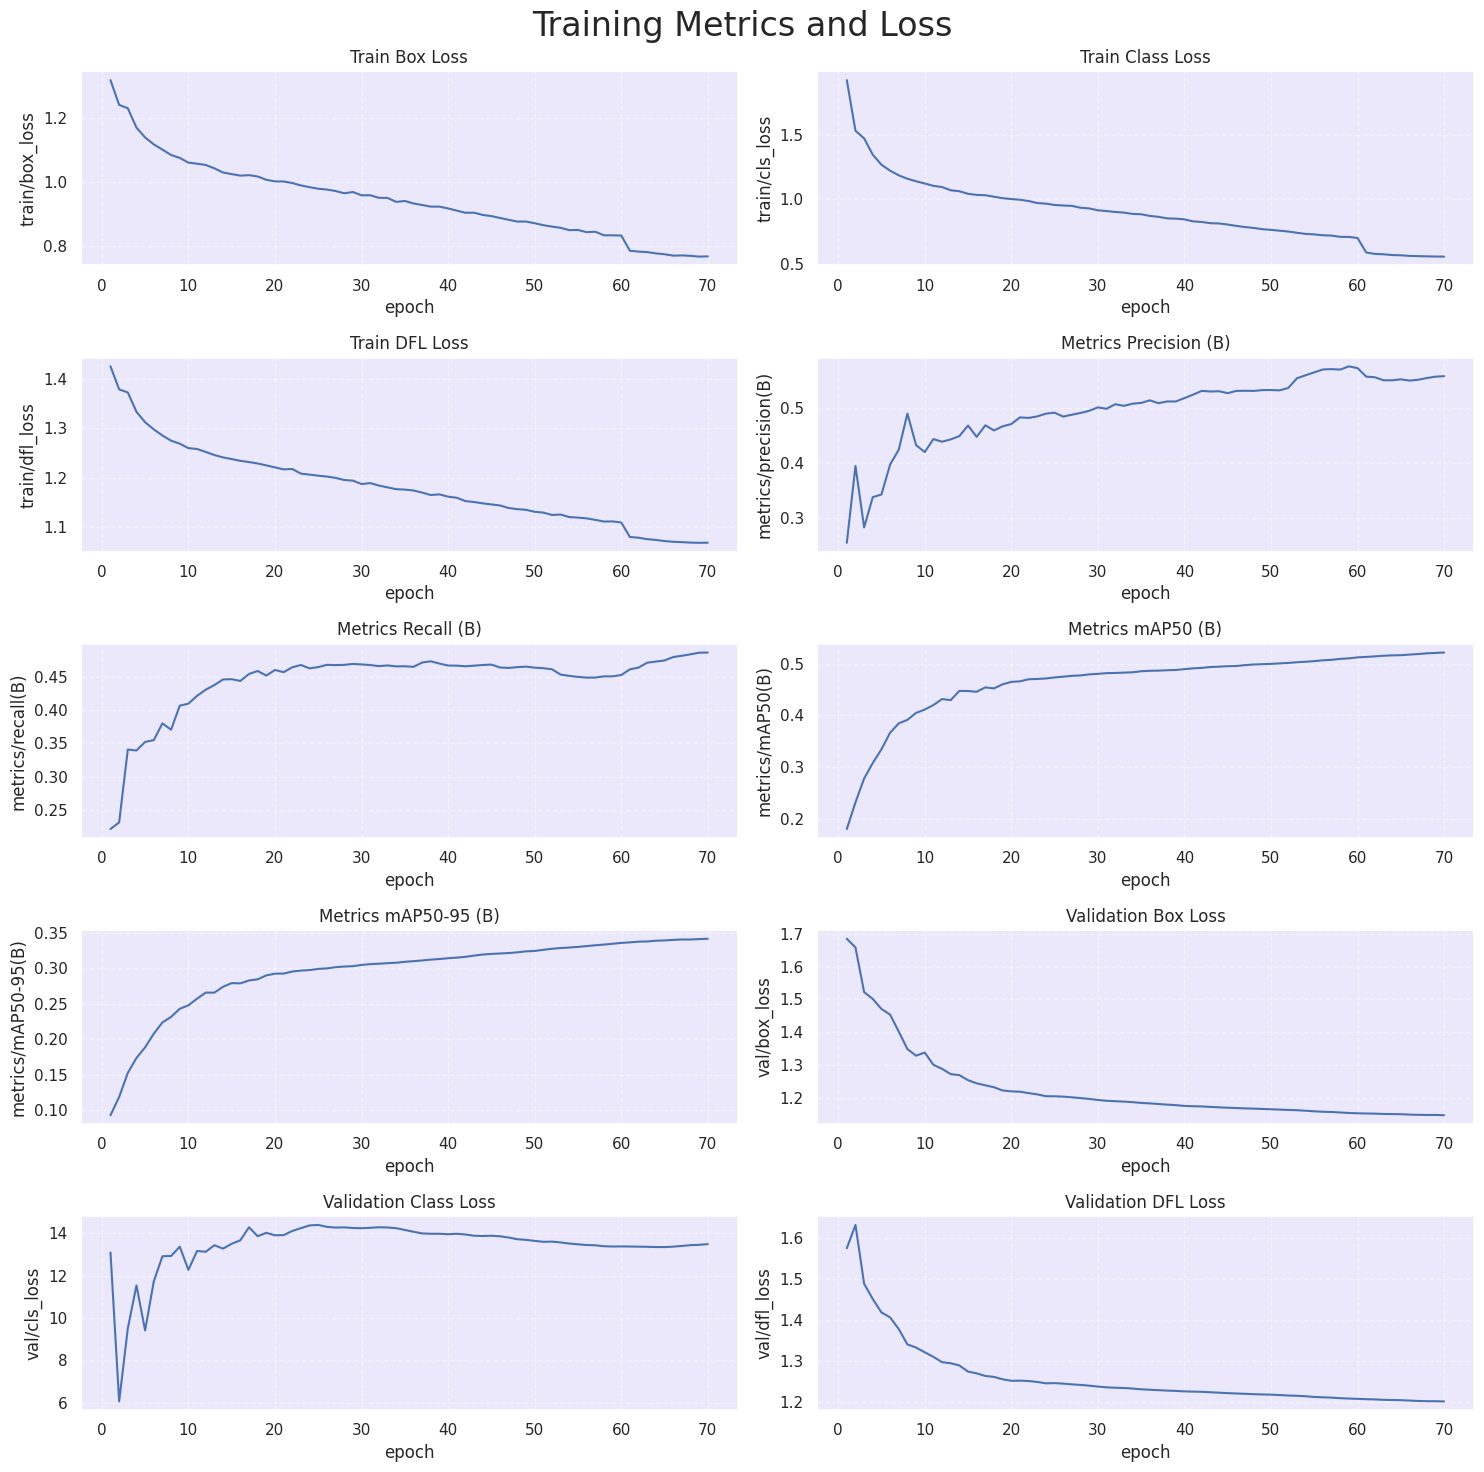

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set your run directory (update this path if needed)
run_dir = '/kaggle/working/train_results/train'  # or 'train1', 'train2' if multiple runs
csv_path = os.path.join(run_dir, 'results.csv')

# Load CSV file
results_df = pd.read_csv(csv_path)

# Clean column names
results_df.columns = results_df.columns.str.strip()

# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot metrics
sns.lineplot(x='epoch', y='train/box_loss', data=results_df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=results_df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=results_df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=results_df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=results_df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=results_df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=results_df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=results_df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=results_df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=results_df, ax=axs[4,1])

# Set titles and style
titles = [
    'Train Box Loss', 'Train Class Loss',
    'Train DFL Loss', 'Metrics Precision (B)',
    'Metrics Recall (B)', 'Metrics mAP50 (B)',
    'Metrics mAP50-95 (B)', 'Validation Box Loss',
    'Validation Class Loss', 'Validation DFL Loss'
]
for ax, title in zip(axs.flat, titles):
    ax.set(title=title)
    ax.grid(linestyle='--', alpha=0.5)

plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()


In [16]:
# Loading the best performing model
Valid_model = YOLO('/kaggle/working/train_results/train/weights/best.pt')

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 51.1±14.9 MB/s, size: 31.5 KB)


val: Scanning /kaggle/input/military-object/military_object_dataset/val/labels... 2941 images, 273 backgrounds, 0 corrupt: 100%|██████████| 2941/2941 [00:03<00:00, 877.18it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/military-object/military_object_dataset/val is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [00:20<00:00,  9.03it/s]


                   all       2941       5081      0.564      0.483      0.522      0.342
    camouflage_soldier        385        510      0.738      0.762      0.781      0.436
                weapon        222        358      0.732      0.553       0.58      0.427
         military_tank        938       1787      0.779      0.844      0.842      0.565
        military_truck         84        148      0.477      0.642      0.618        0.4
      military_vehicle        149        307      0.699      0.447      0.541       0.39
              civilian          1          1          0          0   0.000482   0.000145
               soldier        420        745      0.822      0.636       0.73      0.427
      civilian_vehicle         18         42      0.502      0.381      0.399      0.232
    military_artillery         85        117      0.642      0.245        0.4      0.264
                trench          1          3          0          0          0          0
     military_aircraf

In [17]:
import pandas as pd
results_csv = pd.read_csv('/kaggle/working/train_results/train/results.csv')
print(results_csv.head())
from ultralytics import YOLO

# Load your trained model
model = YOLO('/kaggle/working/train_results/train/weights/best.pt')

# Show all stored metrics
print(model.metrics)

   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   381.935         1.31923         1.92446         1.42549   
1      2   740.570         1.24166         1.53157         1.37884   
2      3  1098.830         1.23111         1.47290         1.37279   
3      4  1453.700         1.17055         1.34592         1.33362   
4      5  1811.260         1.13962         1.26826         1.31250   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.25438            0.22130           0.17982   
1               0.39442            0.23124           0.23153   
2               0.28260            0.34073           0.27776   
3               0.33754            0.33928           0.30788   
4               0.34237            0.35213           0.33428   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.09302       1.68527      13.09530       1.57540  0.067018   
1              0.11877       1.65888  

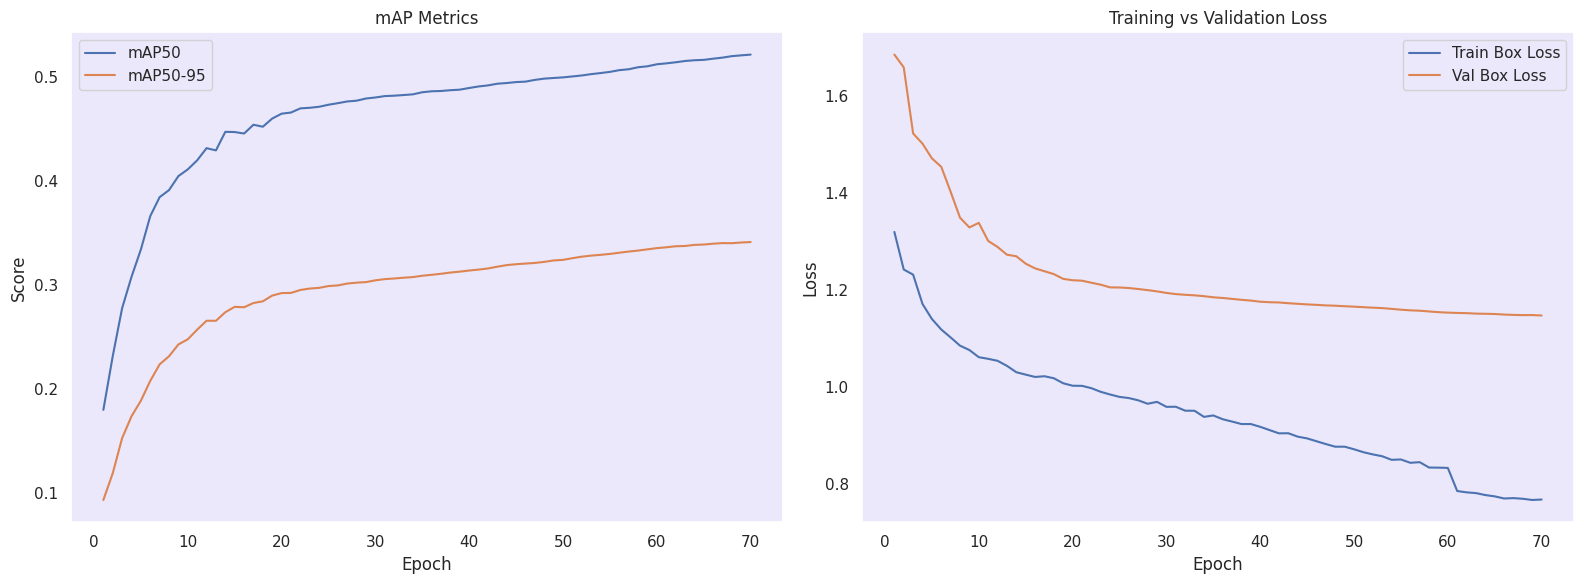

In [18]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot mAP metrics
ax1.plot(results_csv['epoch'], results_csv['metrics/mAP50(B)'], label='mAP50')
ax1.plot(results_csv['epoch'], results_csv['metrics/mAP50-95(B)'], label='mAP50-95')
ax1.set_title('mAP Metrics')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')
ax1.legend()
ax1.grid()

# Plot loss metrics
ax2.plot(results_csv['epoch'], results_csv['train/box_loss'], label='Train Box Loss')
ax2.plot(results_csv['epoch'], results_csv['val/box_loss'], label='Val Box Loss')
ax2.set_title('Training vs Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [19]:
# Export the model
Valid_model.export(format='onnx')

Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/kaggle/working/train_results/train/weights/best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 16, 4725) (5.9 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.53', 'onnxruntime-gpu'] not found, attempting AutoUpdate...


Using Python 3.11.11 environment at: /usr
Resolved 22 packages in 299ms



requirements: AutoUpdate success ✅ 3.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



 Downloaded onnxruntime-gpu
Prepared 4 packages in 2.52s
Installed 4 packages in 14ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.22.0
 + onnxslim==0.1.53



ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 5.5s, saved as '/kaggle/working/train_results/train/weights/best.onnx' (11.6 MB)

Export complete (5.7s)
Results saved to /kaggle/working/train_results/train/weights
Predict:         yolo predict task=detect model=/kaggle/working/train_results/train/weights/best.onnx imgsz=480  
Validate:        yolo val task=detect model=/kaggle/working/train_results/train/weights/best.onnx imgsz=480 data=military_dataset_corrected.yaml  
Visualize:       https://netron.app


'/kaggle/working/train_results/train/weights/best.onnx'

In [20]:
# Export best model to ONNX
!yolo export model=/kaggle/working/runs/train/weights/best.pt format=onnx

# Create submission file
!zip -r /kaggle/working/results.zip /kaggle/working/runs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 955, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/yolo/model.py", line 79, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 151, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 295, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py", line 1540, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
    